# Generating a Micromodel Using an XCT Core (50 x 50)
---

This is an example notebook for creating a micromodel from start to finish. Optionally, ```svglib``` and ```reportlab``` can be used to convert the generated SVG file into a rasterized image, such as a PNG.

**Developed by**:
Aramy Truong, Postbachelors Research Associate - Terrestrial and Atmospheric Processes - Pacific Northwest National Laboratory, Richland, WA, USA.

**Mentors**:
Arunima Bhattacharjee and
Maruti K. Mudunuru

In [ ]:
# Installing svglib and reportlab for exporting to a rasterized image format (does not come included in Pore2Chip requirements)
%pip install svglib
%pip install reportlab==3.6.13

In [1]:
# Importing necessary libraries
from pore2chip import metrics, filter_im, coordination, generate, export
import cv2 as cv
import os
import copy
import numpy as np
from matplotlib import pyplot as plt

# Imported for basic visualization
import porespy as ps
import openpnm as op

from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

path = os.getcwd()

%matplotlib widget
%load_ext autoreload
%autoreload 2

## Inputing Images and Filtering
---
Here is an example for importing XCT images. Pore2Chip has functions for reading an array of images or reading images in a file directory for filtering. Both methods are below. NOTE: PoreSpy treats white pixels as pore space. Use the "invert" parameter to invert the filtered images,

## Method 1:
Read images externally and filter images using ```filter_im.filter```. If you already have images loaded in memory, this function will filter it using Otsu's filtering.

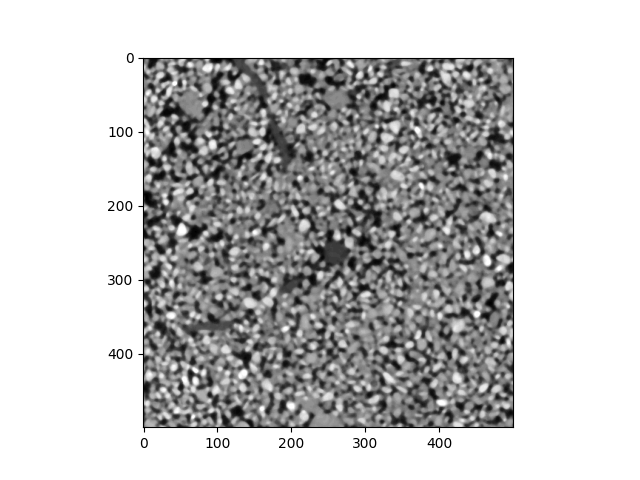

In [2]:
# Set up image path and 3D array to contain input images
image_path = r'bean_bucket_100/'
image_list_3D = np.zeros((100, 500, 500), dtype = np.uint8)

# Load image into each slice in 3D array
stride = 0
for file in os.listdir(image_path):
    image = cv.imread(image_path + file, cv.IMREAD_GRAYSCALE)
    image_list_3D[stride,:,:] = copy.deepcopy(image)
    stride += 1

fig, ax = plt.subplots()
ax.imshow(image_list_3D[9,:,:], cmap='gray')

Here is where we filter the images from image data loaded in memory.

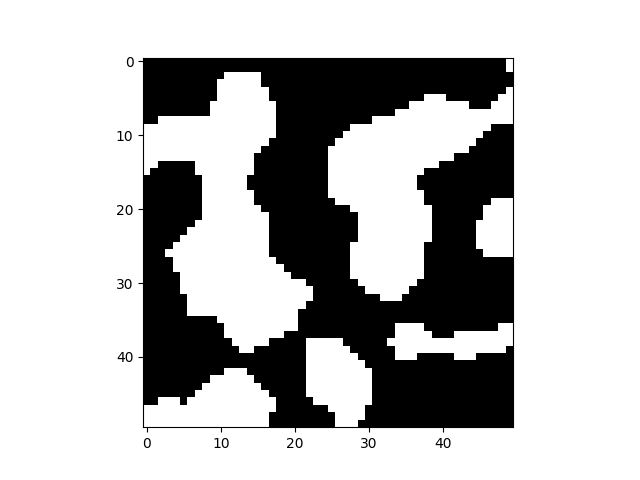

In [3]:
# Filter image and crop image down to 50 x 50, with a depth of 50
filtered_images = filter_im.filter_list(image_list_3D, [0, 50], [0, 50], 50, invert=True)
fig, ax = plt.subplots()
ax.imshow(filtered_images[3,:,:], cmap='gray')

## Method 2:
Input image path and filter using ```filter_im.read_and_filter_list```. This will load and filter the image files in one go. All parameters after the image_path variable are option. If no depth is given, All of the images in the directory will be loaded.

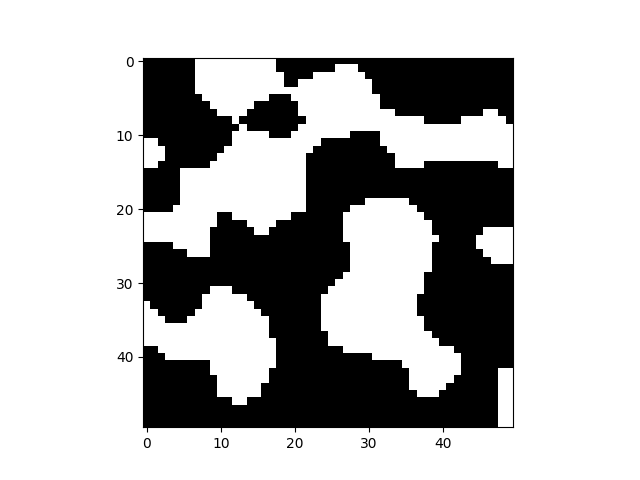

In [2]:
image_path = r'bean_bucket_100/'
# Reads and loads all images in the image_path string. This lines reads and filters a 50 x 50 x 50 3D image set
filtered_images = filter_im.read_and_filter_list(image_path, [0, 50], [0, 50], 50, invert=True)

fig, ax = plt.subplots()
ax.imshow(filtered_images[1,:,:], cmap='gray')

Whichever method you choose, you will have a 3D voxel binary image used to represent the solid and pore space. The cell below visualizes it using PoreSpy's visualization tools.

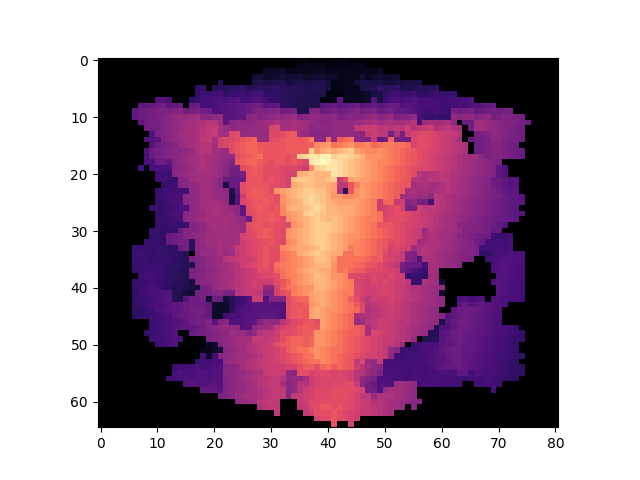

In [5]:
im_3d = ps.visualization.show_3D(filtered_images)
fig, ax = plt.subplots()
ax.imshow(im_3d, cmap=plt.cm.magma)

## Getting Metrics
---
To generate a micromodel, a list of pore diameters, throat diameters, and coordination numbers are required. To extract this information, use the ```metrics``` module.

These next couple code cells extracts pore and throat diameters and displays their distributions in a histogram.

In [3]:
%%capture
# The capture command above stops Jupyter from print long outputs, includding HTML outputs from PoreSpy. It is optional
pore_diameters, throat_diameters = metrics.extract_diameters(filtered_images)

Text(0, 0.5, 'Probability Density')

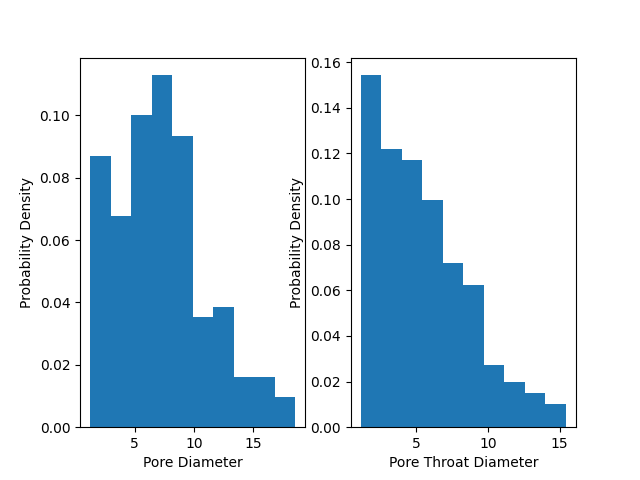

In [7]:
# Plot Probability Densities
fig, ax = plt.subplots(1, 2)

ret = ax[0].hist(pore_diameters, density = True)
ret2 = ax[1].hist(throat_diameters, density = True)
ax[0].set_xlabel("Pore Diameter")
ax[0].set_ylabel("Probability Density")
ax[1].set_xlabel("Pore Throat Diameter")
ax[1].set_ylabel("Probability Density")

The next couple code cells extract the coordination numbers and displays their distributions as a histogram.

In [26]:
%%capture
# Extracts coordination numbers
coordination_numbers = coordination.coordination_nums_3D(filtered_images)
coord_pdf = metrics.get_probability_density(coordination_numbers)

Text(0, 0.5, 'Probability Density')

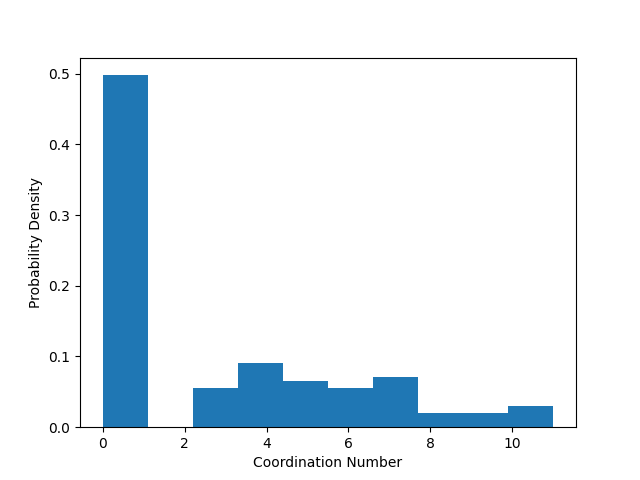

In [9]:
# Plot Probability Densities
fig, ax = plt.subplots()

ret = ax.hist(coordination_numbers, density = True)
ax.set_xlabel("Coordination Number")
ax.set_ylabel("Probability Density")

## Generating the Network
---
In this example, a network is generated using a 10 x 10 pore structure (i.e. 10 pores on each size of the design). Pore diameters, throat diameters, and coordination numbers are required to generate. Their respective probability densities (that all add up to 1) are optional.

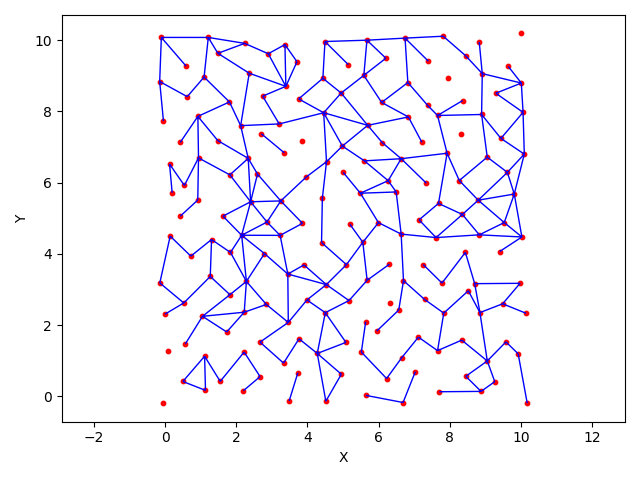

In [35]:
network = generate.generate_network(10, 10, pore_diameters, throat_diameters, coordination_numbers, coord_pdf=coord_pdf, center_channel=2)

h = op.visualization.plot_connections(network)
op.visualization.plot_coordinates(network, ax=h)

In [14]:
print(network)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.BodyCenteredCubic at 0x1e5d0ffcdb0>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  pore.coords                                                     181 / 181
  3  throat.conns                                                    147 / 147
  4  pore.coordination_number                                        181 / 181
  5  pore.max_size                                                   181 / 181
  6  pore.seed                                                       181 / 181
  7  pore.diameter                                                   181 / 181
  8  pore.volume                                                     181 / 181
  9  throat.spacing                                                  13

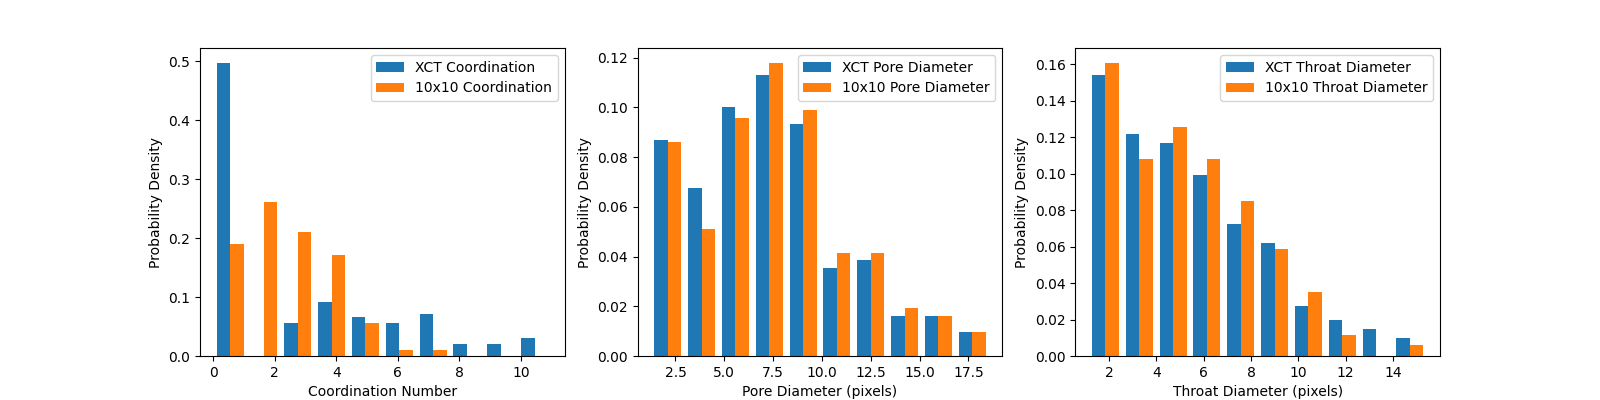

In [36]:
gen_coord = op.models.network.coordination_number(network)

fig, ax = plt.subplots(1, 3, figsize=(16,4))
ret = ax[0].hist([coordination_numbers, gen_coord], density = True)
ret = ax[1].hist([pore_diameters, network['pore.diameter']], density = True)
ret = ax[2].hist([throat_diameters, network['throat.diameter']], density = True)

ax[0].set_xlabel('Coordination Number')
ax[0].set_ylabel('Probability Density')
ax[0].legend(['XCT Coordination', '10x10 Coordination'])
ax[1].set_xlabel('Pore Diameter (pixels)')
ax[1].set_ylabel('Probability Density')
ax[1].legend(['XCT Pore Diameter', '10x10 Pore Diameter'])
ax[2].set_xlabel('Throat Diameter (pixels)')
ax[2].set_ylabel('Probability Density')
ax[2].legend(['XCT Throat Diameter', '10x10 Throat Diameter'])

To save as either an SVG or DXF, use the ```export``` module. NOTE: The "design_size" parameter will decide the final unit width and height of the SVG image, but will also change the distance between pores. Use ```design_size = n * 20``` for the best results. In the example below, ```n = 10```, and so, ```design_size = 200```:

In [37]:
design = export.network2svg(network, 10, 10, 200, 200)

save_path = os.path.dirname(path) + r'\example_outputs\\network.svg'

design.save_svg(save_path)

In [13]:
document = export.network2dxf(network)

save_path_dxf = os.path.dirname(path) + r'\example_outputs\\network.dxf'

document.saveas(save_path_dxf)

To write the SVG file as a rasterized image, we will use ```svglib``` and ```reportlab```:

In [23]:
rldrawing = svg2rlg('example_outputs/network.svg')
renderPM.drawToFile(rldrawing, 'example_outputs/network.png', fmt='PNG')

In [7]:
plt.close('all')